~~~~
~~##############~~

Do stocks trade in patterns? 

Simply look whether the stock closed green/red
Does that create a pattern in the various time periods?

~~##############~~
~~~~

In [ ]:
# ~ Written for Schwabdev ~

In [43]:
import pandas as pd
import json
import random   
from os import path
from datetime import date, timedelta
import yfinance as yf
import stumpy
import numpy as np
# import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [5]:
DATA_DIR = '/Users/luketaylor/Desktop/Python/src_data'
stock_directory = pd.read_csv(path.join(DATA_DIR, 'nasdaq_screener_1699595712769.csv'))

stock_directory.reset_index(inplace=True)
# stock_directory = stock_directory.drop(columns=['Date', 'Unnamed: 0'])
# stock_directory['Datetime'] = pd.to_datetime(
#     stock_directory[['Year', 'Month', 'Day']]
# )
# stock_directory['Range'] = stock_directory['High'] - stock_directory['Low']
# stock_directory['Intraday_change'] = (stock_directory['Close'] - stock_directory['Open']) / stock_directory['Open']
stock_directory.head()

,index,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,0,A,Agilent Technologies Inc. Common Stock,$107.74,-1.6500,-1.508%,3.152335e+10,United States,1999.0,1480927,Industrials,Biotechnology: Laboratory Analytical Instruments
1,1,AA,Alcoa Corporation Common Stock,$24.58,-0.9500,-3.721%,4.386839e+09,United States,2016.0,4072241,Industrials,Aluminum
2,2,AACG,ATA Creativity Global American Depositary Shares,$0.85,-0.0033,-0.387%,2.687884e+07,China,2008.0,10752,Real Estate,Other Consumer Services
3,3,AACI,Armada Acquisition Corp. I Common Stock,$10.75,0.0400,0.373%,0.000000e+00,United States,2021.0,2040,Finance,Blank Checks
4,4,AACIU,Armada Acquisition Corp. I Unit,$10.70,0.0000,0.00%,0.000000e+00,United States,2021.0,1,Finance,Blank Checks


In [6]:
# # url='https://query2.finance.yahoo.com/v8/finance/chart/MMM'
# schwab_app_key = 'V7MbigsGk7zwzSGA03B3Ntm9uWk7n1NZohND0tlH6V9h4vPb'
# schwab_app_secret = 'oLhmoLWqHAbp1aD6zHDhPTovBiFzApG8LIfMWyy1TF93y9wgwD6vrLipqZOm4BN6'

# callback_url = 'https://127.0.0.1'

# Create list of binary strings to find green/red patterns within stock movement
### binary will make every combination of green/red when transcribed to 1s/0s

# something currently not accounted for - long streaks of prior 0s
- i.e. [0,0,0,0,0,0,1] won't be created
- maybe just add on empty binary strings up to length N, e.g.
- [0],[0,0],[0,0,0]....[0,0,...0]

In [7]:
# add binary to an empty binary string
## example
## [0,0,0,0,0] + [1,1,0] = [0,0,1,1,0]
def add_to_tail(base, tail):
    tail_addition_res = base.copy()
    for i in range(1, len(tail) + 1):
        tail_addition_res[-i] += tail[-i]
    return tail_addition_res

print(add_to_tail([0,0,0,0,0], [1,0]))

[0, 0, 0, 1, 0]


In [8]:
def get_binary_string_length(len_binary_string):
    string_list = []
    empty_binary_strings = []
    bit_length = pow(2, len_binary_string)

    # create 0-preceding lists of binary length equal to what's passed as a parameter, starting with
    # [0,0], up to [0,0, ... 0] length = len_binary_string
    for i in range(2,len_binary_string+1):
        xs=list()
        for y in range(0, i):
            xs.append(0)
        empty_binary_strings.append(xs)

    longest_empty_list = max(empty_binary_strings, key=len)

    # print(longest_empty_list)

    # create binary lists
    # [0,1,10,11,100, ... 111]
    for n in range (0, bit_length):
        binary = bin(n)[2:]
        # print(binary)        # '101010'
        binary_string = []
        for pat in binary:
            binary_string.append(int(pat))
        string_list.append(binary_string)

    # add binary lists shorter than the longest empty list such that there are lists w/preceding 0s, i.e.
    # [1,0] with max length [0,0,0,0,0] becomes [0,0,0,1,0]

    # preceding variety
    preceding_binary_0s = []
    for bin_str in string_list:
        # check that the length of the strings are shorter than the longest binary string
        # AND sum > 0 since sum(binary_string) = 0 will be accounted for
        if len(bin_str) < len(longest_empty_list) and sum(bin_str) > 0:
            preceding_binary_0s.append(add_to_tail(longest_empty_list, bin_str))
    return string_list + empty_binary_strings + preceding_binary_0s

binary_strings=(get_binary_string_length(5))
print(binary_strings)

[[0], [1], [1, 0], [1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1], [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 1, 0], [1, 0, 0, 1, 1], [1, 0, 1, 0, 0], [1, 0, 1, 0, 1], [1, 0, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 0, 0], [1, 1, 0, 0, 1], [1, 1, 0, 1, 0], [1, 1, 0, 1, 1], [1, 1, 1, 0, 0], [1, 1, 1, 0, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1], [0, 0], [0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0], [0, 0, 1, 1, 1], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 1, 0], [0, 1, 0, 1, 1], [0, 1, 1, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 1, 0], [0, 1, 1, 1, 1]]


# do we loop between the various periodTypes to see if certain times of the year have better suited patterns?
# patterns within the patterns

In [9]:
today = date.today()
year_lookback = 10

lookback_from_today = today - timedelta(days=year_lookback*365)

print(today)
print(lookback_from_today)

2026-02-10
2016-02-13


    # Intervals (Data Frequency): 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo.

In [32]:
def yfinance_dataframe_creator(stock_symbol, year_lookback_num):
    tick = yf.Ticker(stock_symbol)

    lookback_formatted = str(year_lookback_num) + 'y'
    df_lookback = tick.history(period=lookback_formatted)
    df_lookback.reset_index(inplace=True)
    # df_lookback.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'], inplace=True)
    df_lookback.rename(columns={'Date':'market_datetime'})

    df_lookback['symbol'] = stock_symbol
    df_lookback['market_month'] = df_lookback['Date'].dt.month
    df_lookback['market_year'] = df_lookback['Date'].dt.year
    df_lookback['market_day'] = df_lookback['Date'].dt.day
    df_lookback['market_day_of_week'] = df_lookback['Date'].dt.day_of_week
    df_lookback['market_quarter'] = df_lookback['Date'].dt.quarter
    df_lookback['close_gre_open'] = (df_lookback['Close'] > df_lookback['Open']).astype(int)
    df_lookback.rename(columns={"Date":"market_datetime"},inplace=True)


    df_lookback['open_v_close'] = (df_lookback['Close'] > df_lookback['Open']) * 1
    df_lookback['prev_close'] = df_lookback['Close'].shift(1)
    df_lookback['close_vs_yesterday_close'] = (df_lookback['Close'] > df_lookback['prev_close'])*1
    df_lookback['pct_chng_close_vs_yesterday'] = (df_lookback['Close'] / df_lookback['prev_close'])-1
    return df_lookback

symbol = 'SPY'
num_yrs = 10
# Periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd (year-to-date), max (all available data).

df = yfinance_dataframe_creator(symbol, num_yrs)
print(len(df.market_datetime.unique()))
df.head()

2514


,market_datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,symbol,market_month,market_year,market_day,market_day_of_week,market_quarter,close_gre_open,open_v_close,prev_close,close_vs_yesterday_close,pct_chng_close_vs_yesterday
0,2016-02-11 00:00:00-05:00,154.540188,156.031864,153.480764,154.980911,219058900,0.0,0.0,0.0,SPY,2,2016,11,3,1,1,1,NaN,0,NaN
1,2016-02-12 00:00:00-05:00,156.760729,158.193058,155.913191,158.176117,127632400,0.0,0.0,0.0,SPY,2,2016,12,4,1,1,1,154.980911,1,0.020617
2,2016-02-16 00:00:00-05:00,159.989831,160.871266,159.023638,160.845840,120250700,0.0,0.0,0.0,SPY,2,2016,16,1,1,1,1,158.176117,1,0.016878
3,2016-02-17 00:00:00-05:00,162.015439,163.846125,161.888300,163.473206,136009500,0.0,0.0,0.0,SPY,2,2016,17,2,1,1,1,160.845840,1,0.016335
4,2016-02-18 00:00:00-05:00,163.744418,163.803752,162.490065,162.803650,102343000,0.0,0.0,0.0,SPY,2,2016,18,3,1,0,0,163.473206,0,-0.004096


# Create SPY dataframe

In [54]:
symbol = 'SPY'
num_yrs = 10
# Periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd (year-to-date), max (all available data).
spy_1y_time_series = yfinance_dataframe_creator('SPY', num_yrs)
spy_1y_time_series.head()

,market_datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,symbol,market_month,market_year,market_day,market_day_of_week,market_quarter,close_gre_open,open_v_close,prev_close,close_vs_yesterday_close,pct_chng_close_vs_yesterday
0,2016-02-11 00:00:00-05:00,154.540142,156.031818,153.480719,154.980865,219058900,0.0,0.0,0.0,SPY,2,2016,11,3,1,1,1,NaN,0,NaN
1,2016-02-12 00:00:00-05:00,156.760759,158.193089,155.913221,158.176147,127632400,0.0,0.0,0.0,SPY,2,2016,12,4,1,1,1,154.980865,1,0.020617
2,2016-02-16 00:00:00-05:00,159.989846,160.871281,159.023653,160.845856,120250700,0.0,0.0,0.0,SPY,2,2016,16,1,1,1,1,158.176147,1,0.016878
3,2016-02-17 00:00:00-05:00,162.015439,163.846125,161.888300,163.473206,136009500,0.0,0.0,0.0,SPY,2,2016,17,2,1,1,1,160.845856,1,0.016335
4,2016-02-18 00:00:00-05:00,163.744449,163.803783,162.490095,162.803680,102343000,0.0,0.0,0.0,SPY,2,2016,18,3,1,0,0,163.473206,0,-0.004096


## stumpy matrix profiling the data

In [72]:

your_time_series = spy_1y_time_series.close_vs_yesterday_close.astype(float)
# your_time_series = spy_1y_time_series.pct_chng_close_vs_yesterday.astype(float)
window_size = 50  # Approximately, how many data points might be found in a pattern

matrix_profile = stumpy.stump(your_time_series, m=window_size)
print(matrix_profile)

[[6.655802389839591 2272 -1 2272]
 [7.000624517899665 2273 -1 2273]
 [7.000624517899665 2274 -1 2274]
 ...
 [6.950480468569154 1999 1999 -1]
 [6.85718119765372 1703 1703 -1]
 [6.862628735077968 1704 1704 -1]]


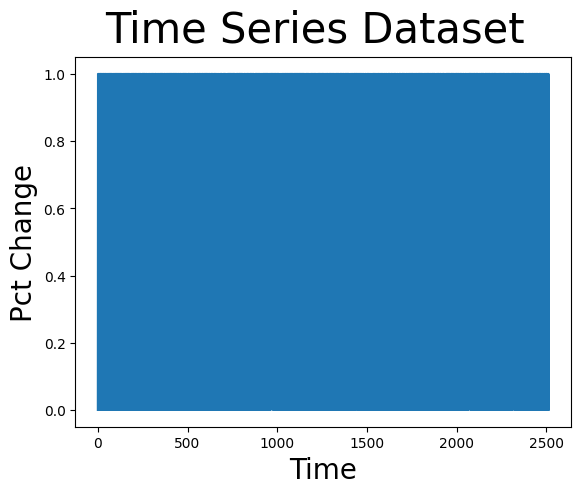

In [77]:
plt.suptitle('Time Series Dataset', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Pct Change', fontsize='20')
# plt.plot(spy_1y_time_series.pct_chng_close_vs_yesterday.values)

plt.plot(spy_1y_time_series.close_vs_yesterday_close.values)
plt.show()

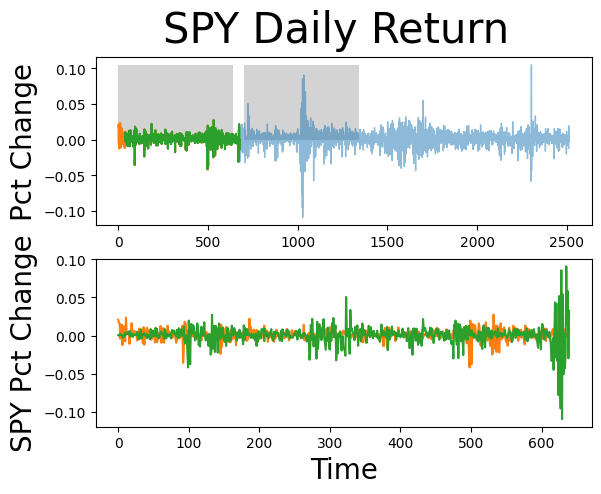

In [66]:
m = 640
max_return = spy_1y_time_series.pct_chng_close_vs_yesterday.max()
min_return = spy_1y_time_series.pct_chng_close_vs_yesterday.min()
fig, axs = plt.subplots(2)
plt.suptitle('SPY Daily Return', fontsize='30')
axs[0].set_ylabel("Pct Change", fontsize='20')
axs[0].plot(spy_1y_time_series.pct_chng_close_vs_yesterday, alpha=0.5, linewidth=1)
axs[0].plot(spy_1y_time_series.pct_chng_close_vs_yesterday.iloc[1:1+m])
axs[0].plot(spy_1y_time_series.pct_chng_close_vs_yesterday.iloc[40:40+m])
rect = Rectangle((1, 0), m, max_return, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((700, 0), m, max_return, facecolor='lightgrey')
axs[0].add_patch(rect)

axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("SPY Pct Change", fontsize='20')
axs[1].plot(spy_1y_time_series.pct_chng_close_vs_yesterday.values[1:1+m], color='C1')
axs[1].plot(spy_1y_time_series.pct_chng_close_vs_yesterday.values[400:400+m], color='C2')
plt.show()

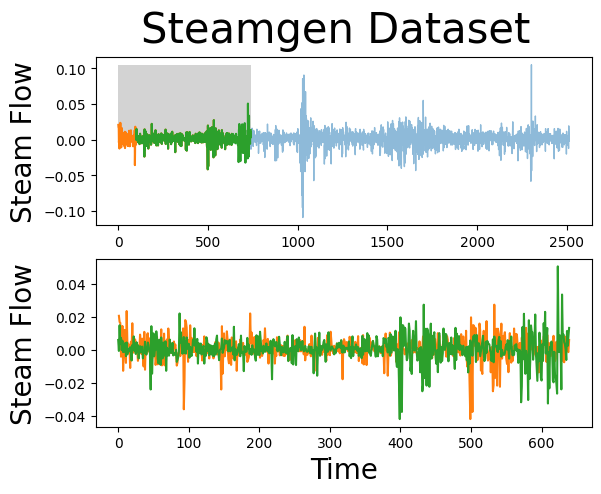

In [71]:
m = 640
max_return = spy_1y_time_series.pct_chng_close_vs_yesterday.max()
min_return = spy_1y_time_series.pct_chng_close_vs_yesterday.min()
fig, axs = plt.subplots(2)
plt.suptitle('Steamgen Dataset', fontsize='30')
axs[0].set_ylabel("Steam Flow", fontsize='20')
axs[0].plot(spy_1y_time_series.pct_chng_close_vs_yesterday, alpha=0.5, linewidth=1)
axs[0].plot(spy_1y_time_series.pct_chng_close_vs_yesterday.iloc[0:0+m])
axs[0].plot(spy_1y_time_series.pct_chng_close_vs_yesterday.iloc[100:100+m])
rect = Rectangle((0, 0), m, max_return, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((100, 0), m, max_return, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Steam Flow", fontsize='20')
axs[1].plot(spy_1y_time_series.pct_chng_close_vs_yesterday.values[0:0+m], color='C1')
axs[1].plot(spy_1y_time_series.pct_chng_close_vs_yesterday.values[100:100+m], color='C2')
plt.show()

# plot 1/0s

<Axes: xlabel='market_datetime'>

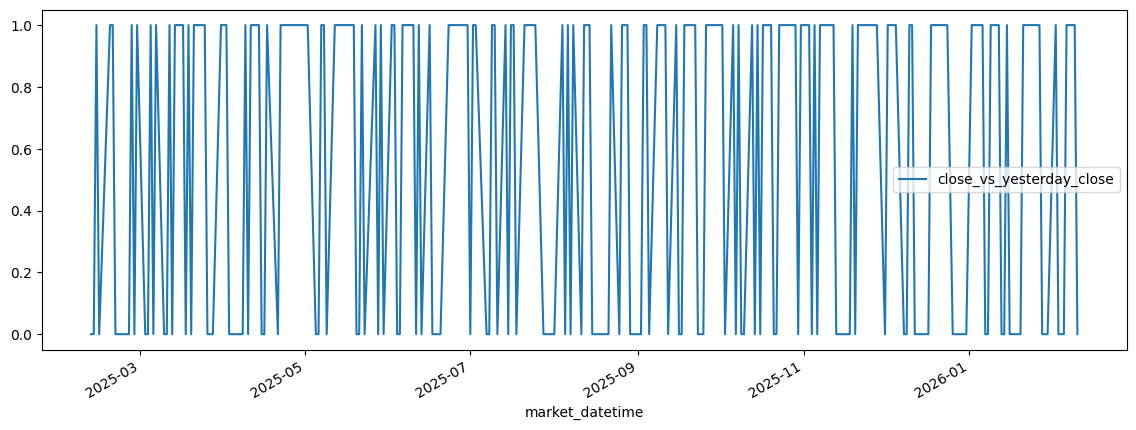

In [31]:
plot_yf_df = spy_1y_time_series[['market_datetime', 'close_vs_yesterday_close']]
# plot_yf_df = plot_yf_df.set_index('market_datetime')
# plot_yf_df.plot()
plot_yf_df.plot(
    x='market_datetime',
    y='close_vs_yesterday_close',
    figsize=(14, 5)
)
# plot_yf_df.plot(
#     x='market_datetime',
#     y='close_vs_yesterday_close',
#     marker='o',
#     linestyle='None'
# )

# pattern match backwards and forwards
### representing every combination of red/green performance
#### think of $SPY has had the performance prior N days
#### red | green | green | red | red | green
## (red: close < open
## (green: open > close
## stock market performance

# Solving:
### given the past red/green days of prior X days, is there a more probable occurrence of a green day given pattern Y
# outcome:
### so i can buy on green days

# questions:
### does seasonality play any part of it?
### eg: in q1 is there more volatility?

# where can i find consistency in the setup?

In [19]:
# yfinance_dataframe_creator

def pattern_checker(yfinance_df, red_green_pattern_list):
    yf_performance_red_green_binary = yfinance_df.open_v_close.tolist()

    matches_forward = []
    matches_backward = []

    # backwards looking match list, uses the past
    inverse_red_green_binary_list = yf_performance_red_green_binary[::-1]

    ## # boundaries of loop range # ##
    # loop through lists of length 1, 2, 3, 4, 5, 6
    for i in range(len(yf_performance_red_green_binary)):

        # 'binary strings' are a list of binary numbers in string format
        # sample data:
        ## [0,1,10,11,100,101,110,111,1000,1001,1010,1011,1110,1111,10000....]
        #
        # for each pattern of 0,1,10,11,100
        for pattern in red_green_pattern_list:
            # get length of pattern to match to lookback window
            patt_len = len(pattern)

            # avoid going out of range
            if i + patt_len <= len(yf_performance_red_green_binary):

                # look at the given spy forward, backward looking lists
                window_forward = yf_performance_red_green_binary[i:i+patt_len]
                window_backward = yf_performance_red_green_binary[i-patt_len:i]

                if window_forward == pattern:
                    matches_forward.append(
                            [pattern
                             , 'forward'
                             , i
                             # pattern FOLLOWS the given date
                             , df['market_datetime'].iloc[i]
                             , df['market_quarter'].iloc[i]
                             , df['market_day'].iloc[i]
                             , df['market_month'].iloc[i]
                             , df['market_year'].iloc[i]
                             , df['open_v_close'].iloc[i]
                             ]
                        )

                if window_backward == pattern:
                    matches_backward.append(
                            [pattern
                                , 'backward'
                                , i
                                # pattern PRECEDES the given date
                                , df['market_datetime'].iloc[i]
                                , df['market_quarter'].iloc[i]
                                , df['market_day'].iloc[i]
                                , df['market_month'].iloc[i]
                                , df['market_year'].iloc[i]
                                , df['open_v_close'].iloc[i]
                            ]
                        )

    # dataframe column names representing data i want in the dataframe
    col_nms=['pattern_matched','direction','index_matched','market_datetime', 'market_quarter', 'market_day', 'market_month', 'market_year', 'open_v_close']

    # create 'backwards' facing dataframe
    # patterns precede the date, so its green given prior 5 day performance
    df_bkwd = pd.DataFrame(matches_backward, columns = col_nms)
    # convert pattern to string for ease of matching (?)
    df_bkwd['pattern_matched_str'] = df_bkwd['pattern_matched'].apply(lambda x: ''.join(map(str, x)))
    df_bkwd['pattern_len'] = df_bkwd['pattern_matched_str'].str.len()
    return df_bkwd


yf_df = yfinance_dataframe_creator('SPY',10)
# yf_df.head()
lst = get_binary_string_length(4) ## patterns up to 30 days long

bckwd_df = pattern_checker(yf_df,lst)
bckwd_df.head(10)

,pattern_matched,direction,index_matched,market_datetime,market_quarter,market_day,market_month,market_year,open_v_close,pattern_matched_str,pattern_len
0,[1],backward,1,2016-02-12 00:00:00-05:00,1,12,2,2016,1,1,1
1,[1],backward,2,2016-02-16 00:00:00-05:00,1,16,2,2016,1,1,1
2,"[1, 1]",backward,2,2016-02-16 00:00:00-05:00,1,16,2,2016,1,11,2
3,[1],backward,3,2016-02-17 00:00:00-05:00,1,17,2,2016,1,1,1
4,"[1, 1]",backward,3,2016-02-17 00:00:00-05:00,1,17,2,2016,1,11,2
5,"[1, 1, 1]",backward,3,2016-02-17 00:00:00-05:00,1,17,2,2016,1,111,3
6,[1],backward,4,2016-02-18 00:00:00-05:00,1,18,2,2016,0,1,1
7,"[1, 1]",backward,4,2016-02-18 00:00:00-05:00,1,18,2,2016,0,11,2
8,"[1, 1, 1]",backward,4,2016-02-18 00:00:00-05:00,1,18,2,2016,0,111,3
9,"[1, 1, 1, 1]",backward,4,2016-02-18 00:00:00-05:00,1,18,2,2016,0,1111,4


In [20]:
red_green_binary_list = df.open_v_close.tolist()

matches_forward = []
matches_backward = []

# backwards looking match list, uses the past
inverse_red_green_binary_list = red_green_binary_list[::-1]

## # boundaries of loop range # ##
# loop through lists of length 1, 2, 3, 4, 5, 6
for i in range(len(red_green_binary_list)):

    # 'binary strings' are a list of binary numbers in string format
    # sample data:
    ## [0,1,10,11,100,101,110,111,1000,1001,1010,1011,1110,1111,10000....]
    #
    # for each pattern of 0,1,10,11,100
    for pattern in binary_strings:
        # get length of pattern to match to lookback window
        patt_len = len(pattern)
        
        # avoid going out of range
        if i + patt_len <= len(red_green_binary_list):

            # look at the given spy forward, backward looking lists
            window_forward = red_green_binary_list[i:i+patt_len]
            window_backward = red_green_binary_list[i-patt_len:i]
            
            if window_forward == pattern:
                matches_forward.append(
                        [pattern
                         , 'forward'
                         , i
                         # pattern FOLLOWS the given date
                         , df['market_datetime'].iloc[i]
                         , df['open_v_close'].iloc[i]
                         , df['market_quarter'].iloc[i]
                         , df['market_day'].iloc[i]
                         , df['market_month'].iloc[i]
                         , df['market_year'].iloc[i]
                         ]
                    )
                
            if window_backward == pattern:
                matches_backward.append(
                        [pattern
                            , 'backward'
                            , i
                            # pattern PRECEDES the given date
                            , df['market_datetime'].iloc[i]
                            , df['open_v_close'].iloc[i]
                            , df['market_quarter'].iloc[i]
                            , df['market_day'].iloc[i]
                            , df['market_month'].iloc[i]
                            , df['market_year'].iloc[i]
                        ]
                    )
                
# dataframe column names representing data i want in the dataframe
col_nms=['pattern_matched','direction','index_matched','market_datetime', 'open_v_close', 'market_quarter', 'market_day', 'market_month', 'market_year']

# create 'backwards' facing dataframe
# patterns precede the date, so its green given prior 5 day performance
df_bkwd = pd.DataFrame(matches_backward, columns = col_nms)
df_fwd = pd.DataFrame(matches_forward, columns = col_nms)
# convert pattern to string for ease of matching (?)
df_bkwd['pattern_matched_str'] = df_bkwd['pattern_matched'].apply(lambda x: ''.join(map(str, x)))
df_fwd['pattern_matched_str'] = df_fwd['pattern_matched'].apply(lambda x: ''.join(map(str, x)))
df_bkwd.tail()

,pattern_matched,direction,index_matched,market_datetime,open_v_close,market_quarter,market_day,market_month,market_year,pattern_matched_str
9945,[0],backward,2511,2026-02-06 00:00:00-05:00,1,1,6,2,2026,0
9946,"[0, 0]",backward,2511,2026-02-06 00:00:00-05:00,1,1,6,2,2026,00
9947,"[0, 0, 0]",backward,2511,2026-02-06 00:00:00-05:00,1,1,6,2,2026,000
9948,[1],backward,2512,2026-02-09 00:00:00-05:00,1,1,9,2,2026,1
9949,[1],backward,2513,2026-02-10 00:00:00-05:00,0,1,10,2,2026,1


In [154]:
# df_bkwd[df_bkwd['market_datetime'] == '2026-01-21 00:00:00-05:00']
df_bkwd[df_bkwd['market_datetime'] == '2026-01-23 00:00:00-05:00']

,pattern_matched,direction,index_matched,market_datetime,open_v_close,market_quarter,market_day,market_month,market_year,pattern_matched_str
9916,[0],backward,2504,2026-01-23 00:00:00-05:00,1,23,1,2026,1,0
9917,"[1, 0]",backward,2504,2026-01-23 00:00:00-05:00,1,23,1,2026,1,10
9918,"[0, 0, 0, 1, 0]",backward,2504,2026-01-23 00:00:00-05:00,1,23,1,2026,1,00010


In [153]:
# df_fwd[df_fwd['market_datetime'].dt.date == '2026-01-23']
df_fwd[df_fwd['market_datetime'] == '2026-01-23 00:00:00-05:00']

,pattern_matched,direction,index_matched,market_datetime,open_v_close,market_quarter,market_day,market_month,market_year
9925,[1],forward,2504,2026-01-23 00:00:00-05:00,1,23,1,2026,1
9926,"[1, 1]",forward,2504,2026-01-23 00:00:00-05:00,1,23,1,2026,1
9927,"[1, 1, 1]",forward,2504,2026-01-23 00:00:00-05:00,1,23,1,2026,1
9928,"[1, 1, 1, 0]",forward,2504,2026-01-23 00:00:00-05:00,1,23,1,2026,1
9929,"[1, 1, 1, 0, 0]",forward,2504,2026-01-23 00:00:00-05:00,1,23,1,2026,1


In [155]:
spy_yf_df = yfinance_dataframe_creator('SPY',1)[['market_datetime','Open','Close']]
spy_yf_df['red_green'] = (spy_yf_df['Close'] > spy_yf_df['Open']).astype(int)
spy_yf_df.tail(15)

,market_datetime,Open,Close,red_green
236,2026-01-15 00:00:00-05:00,694.570007,692.239990,0
237,2026-01-16 00:00:00-05:00,693.659973,691.659973,0
238,2026-01-20 00:00:00-05:00,681.489990,677.580017,0
239,2026-01-21 00:00:00-05:00,679.650024,685.400024,1
240,2026-01-22 00:00:00-05:00,689.849976,688.979980,0
241,2026-01-23 00:00:00-05:00,688.150024,689.229980,1
242,2026-01-26 00:00:00-05:00,690.489990,692.729980,1
243,2026-01-27 00:00:00-05:00,694.179993,695.489990,1
244,2026-01-28 00:00:00-05:00,697.049988,695.419983,0
245,2026-01-29 00:00:00-05:00,696.390015,694.039978,0


# are there preceding patterns that lead to different following patterns?
- e.g. [1,0,1,1] in the prior 4 days has performance of [1,1,1,1] in the following 4 days X% of the time

In [156]:
df_fwd.head()

,pattern_matched,direction,index_matched,market_datetime,open_v_close,market_quarter,market_day,market_month,market_year
0,[0],forward,0,2016-02-08 00:00:00-05:00,1,8,2,2016,0
1,"[0, 1, 0, 1, 1]",forward,0,2016-02-08 00:00:00-05:00,1,8,2,2016,0
2,[1],forward,1,2016-02-09 00:00:00-05:00,1,9,2,2016,1
3,"[1, 0]",forward,1,2016-02-09 00:00:00-05:00,1,9,2,2016,1
4,"[1, 0, 1]",forward,1,2016-02-09 00:00:00-05:00,1,9,2,2016,1


In [163]:
df_fwd_adjusted = df_fwd[['pattern_matched_str','market_datetime']].copy()
df_fwd_adjusted.rename(columns={'pattern_matched_str':'forward_pattern'}, inplace=True)

df_bkwd_adjusted = df_bkwd[['pattern_matched_str','market_datetime','open_v_close','market_quarter','market_day','market_month','market_year']].copy()
df_bkwd_adjusted.rename(columns={'pattern_matched_str':'backward_pattern'}, inplace=True)

df_fwd_and_bkwd = df_bkwd_adjusted.merge(df_fwd_adjusted, how = 'inner', on = 'market_datetime')
df_fwd_and_bkwd.head()

,backward_pattern,market_datetime,open_v_close,market_quarter,market_day,market_month,market_year,forward_pattern
0,0,2016-02-09 00:00:00-05:00,1,1,9,2,2016,1
1,0,2016-02-09 00:00:00-05:00,1,1,9,2,2016,10
2,0,2016-02-09 00:00:00-05:00,1,1,9,2,2016,101
3,0,2016-02-09 00:00:00-05:00,1,1,9,2,2016,1011
4,0,2016-02-09 00:00:00-05:00,1,1,9,2,2016,10111


### dataframe contains prior x days but includes the x+1 day
## allows you to average 1/0 if that day has a close > open
## gives 'pct likelyhood' from the data
### prior performanace doesn't indicate future performance
#### but does it?

(???)

In [ ]:
# Assume 'df' is your DataFrame
# Calculate the middle index
middle_index = len(df_bkwd) // 2

# Define how many rows you want to display around the middle
num_rows_to_display = 10 
half_rows = num_rows_to_display // 2

# Select the rows from the middle
# The slice is from 'middle_index - half_rows' up to (but not including) 'middle_index + half_rows'
middle_rows = df_bkwd.iloc[middle_index - half_rows : middle_index + half_rows]

# Print the result (necessary in some environments like PyCharm)
middle_rows.head()


In [49]:
symbol = 'SPY'
lkbk_yrs = 10
pattern_len = 10

yf_df = yfinance_dataframe_creator(symbol,lkbk_yrs)
# yf_df.head()
list_of_patterns = get_binary_string_length(pattern_len) ## patterns up to 30 days long
# print(pattern_list)
# backward_df = pattern_checker(yf_df,list_of_patterns)
# backward_df.head()

str_by_quarter = backward_df.groupby(
    ['pattern_matched_str','market_quarter']
).agg({
        'open_v_close': 'mean', ## average 1/0 given 'pattern_matched_str' representing preceding days
        'market_datetime': 'count' # number of occurrences with this pattern # are some patterns more likely than others?
        })
# rename for readability
str_by_quarter.rename(columns={
        'open_v_close':'avg_green_v_red',
        'market_datetime':'match_count'
        }, inplace=True)
# str_by_quarter.reset_index(inplace=True)
# str_by_quarter.head(100)

# performance breakdown by pattern length
- tables of lengths and times
- 10 years 2^30 (>1M length patterns to check
- quit after 4 minutes
- len 15 took 20 sec
- 33k (2^15) patterns
- len 10 took 264 ms

In [54]:
str_by_month_match_len = backward_df.groupby(
    ['pattern_matched_str', 'pattern_len','market_month']
).agg({
        'open_v_close': 'mean', ## average 1/0 given 'pattern_matched_str' representing preceding days
        'market_datetime': 'count' # number of occurrences with this pattern # are some patterns more likely than others?
        })

# rename for readability
str_by_month_match_len.rename(columns={
        'open_v_close':'avg_green_v_red',
        'market_datetime':'match_count'
        }, inplace=True)
str_by_month_match_len.reset_index(inplace=True)
str_by_month_match_len['size'] = str_by_month_match_len['avg_green_v_red'] * str_by_month_match_len['match_count']
str_by_month_match_len[str_by_month_match_len.match_count>1].head(10)

## interesting
# pattern 100111
# 2065,100111,6,3,1.000000,7,7.0

,pattern_matched_str,pattern_len,market_month,avg_green_v_red,match_count,size
0,0,1,1,0.658537,82,54.0
1,0,1,2,0.558442,77,43.0
2,0,1,3,0.538462,104,56.0
3,0,1,4,0.524272,103,54.0
4,0,1,5,0.581633,98,57.0
5,0,1,6,0.545455,99,54.0
6,0,1,7,0.636364,88,56.0
7,0,1,8,0.631579,95,60.0
8,0,1,9,0.500000,106,53.0
9,0,1,10,0.452830,106,48.0


In [62]:
bigger_matches_df = str_by_month_match_len[(str_by_month_match_len.match_count>3) & (str_by_month_match_len.pattern_len>1)].copy()
 # .head(10)


In [69]:
bigger_matches_df.columns

Index(['pattern_matched_str', 'pattern_len', 'market_month', 'avg_green_v_red',
       'match_count', 'size', 'rank_green_pctage', 'rank_green_pctage_len_mo',
       'rank_green_pctage_len'],
      dtype='object')

# generated code

1️⃣ Aggregate per pattern, weighting by occurrences

We don’t want rare patterns to dominate.

In [78]:
import numpy as np
import pandas as pd

pattern_stats = (
    bigger_matches_df
    .groupby('pattern_matched_str')
    .apply(lambda x: pd.Series({
        # weighted mean across months
        'weighted_avg_gvr': np.average(
            x['avg_green_v_red'],
            weights=x['match_count']
        ),
        'total_matches': x['match_count'].sum(),
        'num_months': x['market_month'].nunique(),
        'std_gvr': np.average(
            (x['avg_green_v_red'] - np.average(
                x['avg_green_v_red'], weights=x['match_count']
            ))**2,
            weights=x['match_count']
        ) ** 0.5
    }))
    .reset_index()
)
pattern_stats.head()

/var/folders/cy/fpbcb2t94t5gcx446v9p4n9w0000gn/T/ipykernel_40105/3047514542.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bigger_matches_df


,pattern_matched_str,weighted_avg_gvr,total_matches,num_months,std_gvr
0,10,0.545024,633.0,12.0,0.098961
1,100,0.576389,288.0,12.0,0.078465
2,1000,0.540984,122.0,12.0,0.190413
3,10000,0.531915,47.0,8.0,0.211625
4,100000,0.777778,9.0,2.0,0.024845


What this gives you:

weighted_avg_gvr → central performance

total_matches → reliability

num_months → seasonality coverage

std_gvr → stability across months

2️⃣ Filter out statistically weak patterns

This avoids “1 amazing month” patterns.

In [79]:
MIN_MATCHES = 30
MIN_MONTHS = 3

pattern_stats = pattern_stats[
    (pattern_stats['total_matches'] >= MIN_MATCHES) &
    (pattern_stats['num_months'] >= MIN_MONTHS)
]


3️⃣ Normalize metrics (so one doesn’t dominate)

We’ll z-score the important ones.

In [81]:
from scipy.stats import zscore

pattern_stats['z_avg'] = zscore(pattern_stats['weighted_avg_gvr'])
pattern_stats['z_matches'] = zscore(np.log1p(pattern_stats['total_matches']))
pattern_stats['z_months'] = zscore(pattern_stats['num_months'])
pattern_stats['z_stability'] = -zscore(pattern_stats['std_gvr'])  # lower std = better


4️⃣ Final significance score

This is where you encode your definition of “significant”.

In [82]:
pattern_stats['significance_score'] = (
    0.45 * pattern_stats['z_avg'] +
    0.25 * pattern_stats['z_matches'] +
    0.20 * pattern_stats['z_months'] +
    0.10 * pattern_stats['z_stability']
)

5️⃣ Top patterns

In [88]:
top_patterns = (
    pattern_stats
    .sort_values('significance_score', ascending=False)
    .head(50)
)
display(top_patterns)

,pattern_matched_str,weighted_avg_gvr,total_matches,num_months,std_gvr,z_avg,z_matches,z_months,z_stability,significance_score,lift_vs_global
1,100,0.576389,288.0,12.0,0.078465,0.593660,1.416915,0.844835,1.707336,0.961076,0.036907
108,111010,0.717949,39.0,7.0,0.212466,3.514843,-1.034454,-1.561341,-0.930792,0.917718,0.178466
86,11010,0.658537,82.0,11.0,0.251370,2.288833,-0.129594,0.363600,-1.696717,0.900625,0.119054
33,1010,0.611111,162.0,12.0,0.183807,1.310176,0.707025,0.844835,-0.366570,0.898646,0.071629
0,10,0.545024,633.0,12.0,0.098961,-0.053582,2.390773,0.844835,1.303824,0.872931,0.005541
100,11100,0.590361,83.0,12.0,0.157515,0.881993,-0.114748,0.844835,0.151058,0.552283,0.050879
16,10010,0.594595,74.0,11.0,0.113015,0.969347,-0.255230,0.363600,1.027136,0.547832,0.055112
34,10100,0.610169,59.0,10.0,0.136229,1.290745,-0.531839,-0.117635,0.570124,0.481361,0.070687
67,1100,0.548193,166.0,12.0,0.135377,0.011814,0.737077,0.844835,0.586896,0.417242,0.008711
89,110101,0.611111,54.0,10.0,0.196942,1.310176,-0.639698,-0.117635,-0.625157,0.343612,0.071629


In [89]:
str_by_month_match_len[str_by_month_match_len['pattern_matched_str']=='111010']

,pattern_matched_str,pattern_len,market_month,avg_green_v_red,match_count,size
8735,111010,6,1,0.666667,6,4.0
8736,111010,6,2,0.750000,4,3.0
8737,111010,6,3,0.750000,4,3.0
8738,111010,6,4,1.000000,1,1.0
8739,111010,6,5,0.666667,3,2.0
8740,111010,6,6,1.000000,1,1.0
8741,111010,6,7,1.000000,4,4.0
8742,111010,6,8,1.000000,6,6.0
8743,111010,6,9,1.000000,2,2.0
8744,111010,6,10,0.666667,3,2.0


6️⃣ (Optional but powerful) Compare against global baseline

This answers: “Is this pattern actually better than the market?”

In [86]:
global_avg = np.average(
    str_by_month_match_len['avg_green_v_red'],
    weights=str_by_month_match_len['match_count']
)

pattern_stats['lift_vs_global'] = (
    pattern_stats['weighted_avg_gvr'] - global_avg
)

pattern_stats = pattern_stats[
    pattern_stats['lift_vs_global'] > 0
]

display(pattern_stats)


,pattern_matched_str,weighted_avg_gvr,total_matches,num_months,std_gvr,z_avg,z_matches,z_months,z_stability,significance_score,lift_vs_global
0,10,0.545024,633.0,12.0,0.098961,-0.053582,2.390773,0.844835,1.303824,0.872931,0.005541
1,100,0.576389,288.0,12.0,0.078465,0.593660,1.416915,0.844835,1.707336,0.961076,0.036907
2,1000,0.540984,122.0,12.0,0.190413,-0.136952,0.357996,0.844835,-0.496624,0.147175,0.001501
16,10010,0.594595,74.0,11.0,0.113015,0.969347,-0.255230,0.363600,1.027136,0.547832,0.055112
23,10011,0.545455,88.0,12.0,0.198863,-0.044691,-0.043075,0.844835,-0.662981,0.071789,0.005972
28,100111,0.578947,38.0,8.0,0.306214,0.646456,-1.065838,-1.080106,-2.776456,-0.469221,0.039465
33,1010,0.611111,162.0,12.0,0.183807,1.310176,0.707025,0.844835,-0.366570,0.898646,0.071629
34,10100,0.610169,59.0,10.0,0.136229,1.290745,-0.531839,-0.117635,0.570124,0.481361,0.070687
37,10101,0.545455,99.0,12.0,0.165575,-0.044691,0.101381,0.844835,-0.007635,0.173438,0.005972
38,101010,0.588235,34.0,6.0,0.225916,0.838118,-1.199979,-2.042576,-1.195588,-0.450916,0.048753


In [87]:
str_by_month_match_len[str_by_month_match_len['pattern_matched_str']=='100']


,pattern_matched_str,pattern_len,market_month,avg_green_v_red,match_count,size
36,100,3,1,0.666667,21,14.0
37,100,3,2,0.600000,15,9.0
38,100,3,3,0.620690,29,18.0
39,100,3,4,0.655172,29,19.0
40,100,3,5,0.608696,23,14.0
41,100,3,6,0.520000,25,13.0
42,100,3,7,0.500000,20,10.0
43,100,3,8,0.500000,18,9.0
44,100,3,9,0.562500,32,18.0
45,100,3,10,0.451613,31,14.0


7️⃣ Interpretation guide

High weighted_avg_gvr + low std → consistent edge

High num_months → not seasonal noise

High total_matches → trustworthy

High significance_score → best overall bet

In [75]:
# pattern_stats = (
#     bigger_matches_df
#     .assign(weighted_gvr=bigger_matches_df['avg_green_v_red'] * bigger_matches_df['match_count'])
#     .groupby('pattern_matched_str', as_index=False)
#     .agg(
#         weighted_avg_gvr=('weighted_gvr', 'sum'),
#         total_matches=('match_count', 'sum'),
#         num_months=('market_month', 'nunique')
#     )
# )
#
# pattern_stats['weighted_avg_gvr'] /= pattern_stats['total_matches']


In [74]:
import numpy as np

# precompute weighted components
bigger_matches_df['_weighted_gvr'] = bigger_matches_df['avg_green_v_red'] * bigger_matches_df['match_count']

pattern_stats = (
    bigger_matches_df
    .groupby('pattern_matched_str', as_index=False)
    .agg(
        weighted_avg_gvr=('_weighted_gvr', lambda x: x.sum() / bigger_matches_df.loc[x.index, 'match_count'].sum()),
        total_matches=('match_count', 'sum'),
        num_months=('market_month', 'nunique'),
        mean_gvr=('avg_green_v_red', 'mean')
    )
)

print(pattern_stats)

# weighted std (done separately for clarity)
pattern_stats = pattern_stats.merge(
    df.merge(
        pattern_stats[['pattern_matched_str', 'weighted_avg_gvr']],
        on='pattern_matched_str'
    )
    .assign(
        sq_diff=lambda x: (x['avg_green_v_red'] - x['weighted_avg_gvr']) ** 2
    )
    .groupby('pattern_matched_str')
    .apply(lambda x: np.average(x['sq_diff'], weights=x['match_count']) ** 0.5)
    .rename('std_gvr'),
    on='pattern_matched_str'
)

# cleanup
bigger_matches_df.drop(columns=['_weighted_gvr'], inplace=True)


    pattern_matched_str  weighted_avg_gvr  total_matches  num_months  mean_gvr
0                    10          0.545024            633          12  0.543996
1                   100          0.576389            288          12  0.574087
2                  1000          0.540984            122          12  0.535299
3                 10000          0.531915             47           8  0.506597
4                100000          0.777778              9           2  0.775000
..                  ...               ...            ...         ...       ...
133             1111110          0.583333             12           3  0.583333
134             1111111          0.750000             12           2  0.728571
135            11111111          0.833333              6           1  0.833333
136           111111111          0.800000              5           1  0.800000
137          1111111111          0.750000              4           1  0.750000

[138 rows x 5 columns]


KeyError: 'pattern_matched_str'

In [66]:
bigger_matches_df['rank_green_pctage_len_mo'] = (
    bigger_matches_df
    .groupby(['pattern_len', 'market_month'])['avg_green_v_red']
    .rank(method='dense', ascending=False)
)

bigger_matches_df['rank_green_pctage_len'] = (
    bigger_matches_df
    .groupby(['pattern_len'])['avg_green_v_red']
    .rank(method='dense', ascending=False)
)

# df['dense_rank'] = (
#     df
#     .groupby(['col_a', 'col_b'])['col_c']
#     .rank(method='dense', ascending=False)
# )
bigger_matches_df.head(10000)

,pattern_matched_str,pattern_len,market_month,avg_green_v_red,match_count,size,rank_green_pctage,rank_green_pctage_len_mo,rank_green_pctage_len
24,10,2,1,0.640000,50,32.0,1.0,1.0,3.0
25,10,2,2,0.577778,45,26.0,1.0,1.0,8.0
26,10,2,3,0.500000,54,27.0,2.0,2.0,16.0
27,10,2,4,0.473684,57,27.0,1.0,1.0,20.0
28,10,2,5,0.600000,55,33.0,1.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...
10912,1111111,7,1,0.600000,5,3.0,3.0,3.0,8.0
10914,1111111,7,4,0.857143,7,6.0,1.0,1.0,2.0
11036,11111111,8,4,0.833333,6,5.0,1.0,1.0,2.0
11096,111111111,9,4,0.800000,5,4.0,1.0,1.0,1.0


In [56]:
str_by_month_match_len[str_by_month_match_len['pattern_matched_str'] == '100111']

,pattern_matched_str,pattern_len,market_month,avg_green_v_red,match_count,size
2063,100111,6,1,0.50,4,2.0
2064,100111,6,2,1.00,3,3.0
2065,100111,6,3,1.00,7,7.0
2066,100111,6,4,0.00,3,0.0
2067,100111,6,5,0.20,5,1.0
2068,100111,6,6,0.00,2,0.0
2069,100111,6,7,0.40,5,2.0
2070,100111,6,8,0.00,2,0.0
2071,100111,6,9,0.40,5,2.0
2072,100111,6,10,0.75,4,3.0


In [59]:
str_by_month_match_len[str_by_month_match_len['pattern_matched_str'] == '11010']

,pattern_matched_str,pattern_len,market_month,avg_green_v_red,match_count,size
6635,11010,5,1,0.750000,8,6.0
6636,11010,5,2,0.857143,7,6.0
6637,11010,5,3,0.833333,6,5.0
6638,11010,5,4,0.166667,6,1.0
6639,11010,5,5,0.555556,9,5.0
6640,11010,5,6,1.000000,4,4.0
6641,11010,5,7,0.833333,6,5.0
6642,11010,5,8,0.909091,11,10.0
6643,11010,5,9,1.000000,3,3.0
6644,11010,5,10,0.500000,4,2.0


In [52]:
str_by_quarter_match_len = backward_df.groupby(
    ['pattern_matched_str', 'pattern_len','market_quarter']
).agg({
        'open_v_close': 'mean', ## average 1/0 given 'pattern_matched_str' representing preceding days
        'market_datetime': 'count' # number of occurrences with this pattern # are some patterns more likely than others?
        })

# rename for readability
str_by_quarter_match_len.rename(columns={
        'open_v_close':'avg_green_v_red',
        'market_datetime':'match_count'
        }, inplace=True)
str_by_quarter_match_len.reset_index(inplace=True)
str_by_quarter_match_len['size'] = str_by_quarter_match_len['avg_green_v_red'] * str_by_quarter_match_len['match_count']
str_by_quarter_match_len[str_by_quarter_match_len.match_count>1].head(1000)

,pattern_matched_str,pattern_len,market_quarter,avg_green_v_red,match_count,size
0,0,1,1,0.581749,263,153.0
1,0,1,2,0.550000,300,165.0
2,0,1,3,0.584775,289,169.0
3,0,1,4,0.491639,299,147.0
4,1,1,1,0.564470,349,197.0
...,...,...,...,...,...,...
4326,110000100,9,4,0.500000,2,1.0
4359,11000011,8,1,0.500000,2,1.0
4360,11000011,8,3,1.000000,2,2.0
4361,11000011,8,4,0.200000,5,1.0


# is there a sweet spot for time period vs quarter improvements

# how to incorporate legitimacy out of a high pctage?
# pct of total matches for the given str length?


# grab the unique varieties of red/green days

In [ ]:
grouped_df = df_bkwd.groupby(
    ['pattern_matched_str']
).agg({
        'open_v_close': 'mean', ## average 1/0 given 'pattern_matched_str' representing preceding days
        'market_datetime': 'count' # number of occurrences with this pattern # are some patterns more likely than others?
        })
grouped_df.reset_index(inplace=True)

# rename for readability
grouped_df.rename(columns={
        'open_v_close':'avg_green_v_red',
        'market_datetime':'match_count'
        }, inplace=True)

# how do i represent high pct high match occurrences (for that length of str?)
# we want a high avg_green_v_red
grouped_df['pct_scaled'] = grouped_df['avg_green_v_red'] * grouped_df['match_count']
grouped_df.reset_index(inplace=True)
grouped_df.sort_values(by='pct_scaled', ascending=False).head(25)

# add a grouby column
## does that make the avg_green_v_red any higher?
## more likelyhood given the quarter?

In [ ]:
grouped_df_2 = df_bkwd.groupby(
    ['pattern_matched_str','market_quarter']
).agg({
        'open_v_close': 'mean', ## average 1/0 given 'pattern_matched_str' representing preceding days
        'market_datetime': 'count' # number of occurrences with this pattern # are some patterns more likely than others?
        })
grouped_df_2.reset_index(inplace=True)

# rename for readability
grouped_df_2.rename(columns={
        'open_v_close':'avg_green_v_red',
        'market_datetime':'match_count'
        }, inplace=True)

# how do i represent high pct high match occurrences (for that length of str?)
# we want a high avg_green_v_red
grouped_df_2['pct_scaled'] = grouped_df_2['avg_green_v_red'] * grouped_df_2['match_count']
grouped_df_2.reset_index(inplace=True)
grouped_df_2.sort_values(by='pct_scaled', ascending=False).head(25)

 # interesting
 ## appears the likelihood of a green day is higher in quarters 2&3
 ## how does this look by X+1 years?
 # is there a rolling window aspect to investigate?

#backward

In [ ]:
df = pd.DataFrame(matches_forward, columns = col_nms)
df['pattern_matched_str'] = df['pattern_matched'].apply(lambda x: ''.join(map(str, x)))


x=df_bkwd.market_datetime.min()
min_bkwd_dt = pd.Timestamp(x)


min_day = min_bkwd_dt.day
min_mo = min_bkwd_dt.month
min_yr = min_bkwd_dt.year

print(min_day)
# df[(df.market_day==min_day)&(df.market_month==min_mo)&(df.market_year==min_yr)]
df[
    (df.market_year==2020)&
    (df.market_month==11)
    & (df.market_day>=27)
]



join the above together to get the combinations of forward and backwards patterns
- can associate 

In [ ]:
df_orders.tail(10)

In [ ]:
df_orders.head(10)

In [ ]:
import yfinance as yf

ticker_invg='SPY'
tick_chart_data = yf.Ticker(ticker_invg).history(period = '10y')
tick_chart_data.reset_index(inplace=True)
tick_chart_data.tail(10)

In [ ]:
df_orders.to_csv('spy_market_data_10y_daily.csv')
df.to_csv('spy_matches_10y_daily.csv')

In [ ]:

result = (
    df.groupby('pattern_matched_str')
      .agg(
          count=('index_matched', 'count'),
          avg=('index_matched', 'mean')
      )
)

result.rename(columns={
    "count": "matches",
    "avg": "average_match_index"
}, inplace=True)

result.reset_index(inplace=True)
result.sort_values(by='matches', ascending=False, inplace=True)

display(result)

In [ ]:
result.head(15)

In [ ]:
print(red_green_binary_list)

In [ ]:
ticka = 'INTC'

call = client.price_history(ticka, periodType='year', period=2, frequencyType="daily").json()

# Load the JSON data
json_data = json.loads(json.dumps(call)) # Example: if starting with a Python dict

# Normalize the 'orders' list
df_orders = pd.json_normalize(json_data, record_path='candles', meta=['symbol'])

# convert timestamp to datetime
df_orders['market_datetime'] = df_orders['datetime'].apply(convert_ms_timestamp_to_pst)

#  1 for close > open (Green)
#  0 for close < open (red)
df_orders['open_v_close'] = (df_orders['close'] > df_orders['open']) * 1
df_orders.head()

In [ ]:
# ticka = 'MMM'

# time_interval = '15m' ## Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]
# date_lookback = '1d'
# yf.enable_debug_mode()
# ticker_behavior = yf.Ticker(ticka).history(period='1d')# date_lookback, interval=time_interval)
# ticker_behavior.reset_index(inplace=True)
# ticker_behavior.head()

In [ ]:
# https://api.schwabapi.com/marketdata/v1/pricehistory?symbol=AAPL&periodType=year&period=2

In [ ]:

## commented out for testing purposes
# size = 100
# lst = [random.choice([0, 1]) for _ in range(size)]

lst = df_orders.open_v_close.tolist()

print(lst)

# loop through green/red and find pattern matches

## loop forward and backwards
- currently projections look forward
- if we want to answer % of 1 after a certain pattern, need the picture from the backwards looking pattern 

In [ ]:
matches = []

for i in range(len(lst)):
    for pattern in binary_strings:
        plen = len(pattern)
        
        # avoid going out of range
        if i + plen <= len(lst):
            window = lst[i:i+plen]
            
            if window == pattern:
                matches.append([pattern, i])
                # print(f"Matched pattern {pattern} at index {i}")

# print(matches)

df = pd.DataFrame(matches, columns = ['pattern_matched','index_matched'])
df['pattern_matched_str'] = df['pattern_matched'].apply(lambda x: ''.join(map(str, x)))

result = (
    df.groupby('pattern_matched_str')
      .agg(
          count=('index_matched', 'count'),
          avg=('index_matched', 'mean')
      )
)

result.rename(columns={
    "count": "matches",
    "avg": "average_match_index"
}, inplace=True)

result.reset_index(inplace=True)

display(result)

In [ ]:
df[df['pattern_matched_str']=='10']

In [ ]:
ticka = 'SPY'

time_interval = '5m' ## Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]
date_lookback = '60d'
# yf.enable_debug_mode()
ticker_behavior = yf.Ticker(ticka).history(period='1d')# date_lookback, interval=time_interval)
ticker_behavior.reset_index(inplace=True)

ticker_behavior['Date'] = ticker_behavior['Datetime'].dt.date
ticker_behavior['Time'] = ticker_behavior['Datetime'].dt.time
ticker_behavior['Range'] = ticker_behavior['High'] - ticker_behavior['Low']
ticker_behavior['Open_Close_Change'] = (ticker_behavior['Close'] - ticker_behavior['Open']) / ticker_behavior['Open']
ticker_behavior['Symbol'] = ticka

ticker_behavior.drop(columns={'Dividends', 'Stock Splits', 'Capital Gains'},inplace=True)
ticker_behavior['DayOfWeek'] = pd.to_datetime(ticker_behavior['Datetime']).dt.day_name()
ticker_behavior.head()



max_time_by_day = ticker_behavior.groupby('Date')['Time'].max().reset_index()
min_time_by_day = ticker_behavior.groupby('Date')['Time'].min().reset_index()

latest_close = ticker_behavior.merge(max_time_by_day, how="inner", on=['Date','Time'])[['Date','Close']]
first_open = ticker_behavior.merge(min_time_by_day, how="inner", on=['Date','Time'])[['Date','Open']]
# result.head()
latest_close.head()

open_and_close = first_open.merge(latest_close, how='left',on='Date')
open_and_close['Yesterday_close'] = open_and_close['Close'].shift(1)

open_and_close['Intraday_Performance'] = (open_and_close['Close'] - open_and_close['Open']) / open_and_close['Open']
open_and_close['Close_to_close_performance'] = (open_and_close['Close'] - open_and_close['Yesterday_close']) / open_and_close['Yesterday_close']
open_and_close['Close_to_close_performance'] = open_and_close['Close_to_close_performance'].fillna(0)

# open_and_close.tail()

d2d_perf_cols = ['Date','Intraday_Performance','Close_to_close_performance']

df_w_perf = ticker_behavior.merge(open_and_close[d2d_perf_cols], how='left',on='Date')
df_w_perf.head()

# intraday_w_close = ticker_behavior.merge(latest_close[['Date','Close']],how='left',on='Date')
# intraday_w_close.head()

In [ ]:
dt_list = ticker_behavior.Date.unique().tolist()
date_index = 5
single_day = ticker_behavior[ticker_behavior.Date == dt_list[date_index]].copy() ## for right now choose day out of the list
day_open = single_day['Open'].iloc[0] ## first open of the day
day_close = single_day['Close'].iloc[-1] ## last close of the day
day_perf = (day_close-day_open) / day_open 
## compare end of day close to current close to get the remaining performance for the stock
single_day['day_perf'] = day_perf
single_day['remaining_gain'] = (day_close - single_day['Close']) / single_day['Close'] 

max_remaining_gain = single_day.remaining_gain.max()
gain_threshold = .1


df_within_threshold = single_day[single_day.remaining_gain >= max_remaining_gain*(1-gain_threshold)] ## show spots w/in (1-gain_threshold)% of max gain
display(df_within_threshold) 

# display(single_day)

In [ ]:
# available dates
dt_list = ticker_behavior.Date.unique().tolist()
# Define column names
columns = ticker_behavior.columns.to_list()

# Create an empty DataFrame
master_df = pd.DataFrame(columns=columns)

for dts in dt_list:
    
    single_day = ticker_behavior[ticker_behavior.Date == dts].copy() ## for right now choose day out of the list
    day_open = single_day['Open'].iloc[0] ## first open of the day
    day_close = single_day['Close'].iloc[-1] ## last close of the day
    day_perf = (day_close-day_open) / day_open 
    ## compare end of day close to current close to get the remaining performance for the stock
    single_day['day_perf'] = day_perf
    single_day['remaining_gain'] = (day_close - single_day['Close']) / single_day['Close'] 

    max_remaining_gain = single_day.remaining_gain.max()
    gain_threshold = .1


    df_within_threshold = single_day[single_day.remaining_gain >= max_remaining_gain*(1-gain_threshold)] ## show spots w/in (1-gain_threshold)% of max gain
    # display(df_within_threshold) 

    # print('day of week:') 
    # print(df_within_threshold.DayOfWeek.unique()[0])
    # print('day perf:')
    # print(round(day_perf,4))
    # print('max remaining perf:')
    # print(round(max_remaining_gain,4))
    # print('span close to max gain')
    # print(len(df_within_threshold))
    # print('earliest time w/max gain')
    # print(df_within_threshold.Time.min())
    # print('latest time w/max gain')
    # print(df_within_threshold.Time.max())
    
    master_df = pd.concat([master_df, df_within_threshold], ignore_index=True)

    
display(master_df)

In [ ]:
# df_w_perf['Datetime'] = df_w_perf['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
# df_w_perf['Date'] = df_w_perf['Date'].astype(str)
# df_w_perf['Time'] = df_w_perf['Time'].astype(str)
df_w_perf['Close_to_close_performance'] = df_w_perf['Close_to_close_performance'].fillna(0)
df_w_perf.head()

In [ ]:
df_w_perf.dtypes

In [ ]:
# master_df.columns
master_df['Datetime'] = master_df['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
master_df['Date'] = master_df['Date'].astype(str)
master_df['Time'] = master_df['Time'].astype(str)

In [ ]:
# sheet: spy_intraday_analysis
# tab: data

import gspread

# df = df_w_perf.copy() ## if using this, change range to 'data!B1'
df = master_df.copy() ## if using this, change range to 'data!S1'

# Paste dataframe to google sheet
# Convert DataFrame to list of lists
stock_info_list = df.values.tolist()

# Include headers if needed
headers = df.columns.tolist()
stock_info_list.insert(0, headers)

sa = gspread.service_account()
sh = sa.open("spy_intraday_analysis")

# Load to Google Sheets
sh.values_update(
    # range='data!B1',  # Corrected keyword argument
    range='data!S1',  # Corrected keyword argument
    params={
        'valueInputOption': 'USER_ENTERED'
    },
    body={
        'values': stock_info_list
    }
)



In [ ]:
# master_df.to_csv('spy_intraday_analysis_02132025_thru_05092025.csv')
# ticker_behavior.to_csv('full_day_spy_intraday_analysis_02132025_thru_05092025.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

def stock_plt_maker(df_inp, ticker_2_invg, perf='0%'):
    """
    Generates a stock plot from the DataFrame and saves it to a file.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'Date', 'Close', and 'Volume' columns.
    filename (str): Name of the file to save the plot.
    df_year (int): Year of the stock data.
    ticker_2_invg (str): Stock ticker symbol.
    perf (str): Performance description to add to the title.
    """
    # Ensure the DataFrame has a DateTime index
    df = df_inp.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Generate synthetic 'Open', 'High', 'Low' prices if not present
    if 'Open' not in df or 'High' not in df or 'Low' not in df:
        df.loc[:, 'Open'] = df['Close'] * (1 + np.random.uniform(-0.01, 0.01, len(df)))
        df.loc[:, 'High'] = df[['Open', 'Close']].max(axis=1) * (1 + np.random.uniform(0, 0.01, len(df)))
        df.loc[:, 'Low'] = df[['Open', 'Close']].min(axis=1) * (1 - np.random.uniform(0, 0.01, len(df)))
    
    chart_title = f"\n \n Ticker: {ticker_2_invg} \nPeriod: {df_inp['Date'].min().strftime('%m/%d/%Y')} - {df_inp['Date'].max().strftime('%m/%d/%Y')} \n Performance: {perf}"
        
    # Plotting the chart
    fig, axlist = mpf.plot(
        df,
        type='candle',                # type of plot: 'candle' for candlestick chart
        volume=True,                  # include volume subplot
        title=chart_title,            # title of the chart
        ylabel='Price',               # y-axis label for price
        ylabel_lower='Volume',        # y-axis label for volume
        figratio=(14, 7),             # figure size
        style='charles',              # chart style
        returnfig=True                # return the figure to add legend
    )

    # Calculate additional values
    high = df['High'].max()
    low = df['Low'].min()
    open_ = df['Open'].iloc[0]
    close = df['Close'].iloc[-1]
    avg_daily_volume = round(df['Volume'].mean()/1000000.0,3)

    # Add values to the left side of the plot
    textstr = '\n'.join((
        f'Open: {open_:.2f}',
        f'Close: {close:.2f}',
        f'High: {high:.2f}',
        f'Low: {low:.2f}',
        f'Avg Daily Volume: {avg_daily_volume:.2f}M'
    ))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axlist[0].text(0.02, 0.98, textstr, transform=axlist[0].transAxes, fontsize=12,
                   verticalalignment='top', bbox=props, ha='left')
    
# stock_plt_maker(perf_by_week_df, 'sbux_weekly_test.png', '2024', ticka, perf_calc_formatted)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

def stock_plt_maker(df_inp, filename, df_year, ticker_2_invg, perf='0%'):
    """
    Generates a stock plot from the DataFrame and saves it to a file.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'Date', 'Close', and 'Volume' columns.
    filename (str): Name of the file to save the plot.
    df_year (int): Year of the stock data.
    ticker_2_invg (str): Stock ticker symbol.
    perf (str): Performance description to add to the title.
    """
    # Ensure the DataFrame has a DateTime index
    df = df_inp.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Generate synthetic 'Open', 'High', 'Low' prices if not present
    if 'Open' not in df or 'High' not in df or 'Low' not in df:
        df.loc[:, 'Open'] = df['Close'] * (1 + np.random.uniform(-0.01, 0.01, len(df)))
        df.loc[:, 'High'] = df[['Open', 'Close']].max(axis=1) * (1 + np.random.uniform(0, 0.01, len(df)))
        df.loc[:, 'Low'] = df[['Open', 'Close']].min(axis=1) * (1 - np.random.uniform(0, 0.01, len(df)))

    # # Calculate moving averages
    # df['20 EMA'] = df['Close'].ewm(span=20, adjust=False).mean()
    # df['50 EMA'] = df['Close'].ewm(span=50, adjust=False).mean()
    # df['90 EMA'] = df['Close'].ewm(span=90, adjust=False).mean()
    
    # Define moving averages to be added to the plot
#     add_plot = [
# #         mpf.make_addplot(df['20 EMA'], color='green', linestyle='--', label='20 EMA'),
# #         mpf.make_addplot(df['50 EMA'], color='red', linestyle='-', label='50 EMA'),
# #         mpf.make_addplot(df['90 EMA'], color='blue', linestyle='-', label='90 EMA')
#     ]
    
    chart_title = f"\n \n Ticker: {ticker_2_invg} \nPeriod: {df_inp['Date'].min().strftime('%m/%d/%Y')} - {df_inp['Date'].max().strftime('%m/%d/%Y')} \n Performance: {perf}"
        
    # Plotting the chart
    fig, axlist = mpf.plot(
        df,
        type='candle',                # type of plot: 'candle' for candlestick chart
        volume=True,                  # include volume subplot
#         addplot=add_plot,             # additional plots (e.g., moving averages)
        title=chart_title,            # title of the chart
        ylabel='Price',               # y-axis label for price
        ylabel_lower='Volume',        # y-axis label for volume
        figratio=(14, 7),             # figure size
        style='charles',              # chart style
        returnfig=True                # return the figure to add legend
    )

#     # Adding the legend
#     legend = axlist[0].legend(loc='upper left')
    
#     # Adding percentage change annotations
#     for date, row in df.iterrows():
#         if not np.isnan(row['Pct_change_daily']):
#             axlist[0].annotate(f"{row['Pct_change_daily']:.2f}%", 
#                                (date, row['Close']), 
#                                textcoords="offset points", 
#                                xytext=(0, 10), 
#                                ha='center', fontsize=8, color='black')
    
    # Create a secondary y-axis for volume on the left side
#     ax_volume = axlist[1].twinx()
#     ax_volume.set_ylabel('Volume')
#     ax_volume.grid(False)  # Disable grid for the secondary axis

    # Calculate additional values
    high = df['High'].max()
    low = df['Low'].min()
    open_ = df['Open'].iloc[0]
    close = df['Close'].iloc[-1]
    avg_daily_volume = round(df['Volume'].mean()/1000000.0,3)

    # Add values to the left side of the plot
    textstr = '\n'.join((
        f'Open: {open_:.2f}',
        f'Close: {close:.2f}',
        f'High: {high:.2f}',
        f'Low: {low:.2f}',
        f'Avg Daily Volume: {avg_daily_volume:.2f}M'
    ))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axlist[0].text(0.02, 0.98, textstr, transform=axlist[0].transAxes, fontsize=12,
                   verticalalignment='top', bbox=props, ha='left')

#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#     # Adjust the position of the text
#     text_x_position = df.index[0]  # You can set it to any specific date if needed
#     text_y_position = (high + low) / 2  # You can adjust this to position the text properly

#     axlist[0].text(text_x_position, text_y_position, textstr, fontsize=12,
#                    verticalalignment='center', bbox=props, ha='left')

    # Hide the axes
#     axlist[0].get_xaxis().set_visible(False)
#     axlist[0].get_yaxis().set_visible(False)

    # # Save the figure
    # fig.savefig(filename)
    # plt.close(fig)
    
# stock_plt_maker(perf_by_week_df, 'sbux_weekly_test.png', '2024', ticka, perf_calc_formatted)

In [ ]:
ticka = 'SPY'

time_interval = '5m' ## Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]
date_lookback = '60d'
ticker_behavior = yf.Ticker(ticka).history(period=date_lookback, interval=time_interval)
ticker_behavior.reset_index(inplace=True)

ticker_behavior['Date'] = ticker_behavior['Datetime'].dt.date
ticker_behavior['Time'] = ticker_behavior['Datetime'].dt.time
ticker_behavior['Open_Close_Change'] = (ticker_behavior['Close'] - ticker_behavior['Open']) / ticker_behavior['Open']
ticker_behavior['Symbol'] = ticka

ticker_behavior.drop(columns={'Dividends', 'Stock Splits', 'Capital Gains'},inplace=True)
ticker_behavior.head()

In [ ]:
total_daily_volume = ticker_behavior.copy()
total_daily_volume['today_vol'] = total_daily_volume.groupby('Date')['Volume'].transform('sum')
total_daily_volume['pct_of_daily_volume'] = total_daily_volume['Volume'] / total_daily_volume['today_vol']
# display(total_daily_volume)

In [ ]:
# Define the target time as a datetime.time object
open_timestamp = dt.time(9, 30, 0)

# Filter the DataFrame for rows where Time is exactly 09:30:00
open_time = total_daily_volume[total_daily_volume['Time'] == open_timestamp]
open_by_datetime = open_time[['Date','Open']]
# open_by_datetime.head()

In [ ]:
intraday_analysis_w_open = total_daily_volume.merge(open_by_datetime, how='left', on='Date')
intraday_analysis_w_open = intraday_analysis_w_open.rename(columns={'Open_y':'Day_Open', 'Open_x':'Open'})
intraday_analysis_w_open['Cumulative_Performance'] = (intraday_analysis_w_open['Close'] - intraday_analysis_w_open['Day_Open']) / intraday_analysis_w_open['Day_Open']
# intraday_analysis_w_open[intraday_analysis_w_open['Date'] == dt.date(2025,3,24)].tail()
# intraday_analysis_w_open.head()

In [ ]:
df_volume_analysis = intraday_analysis_w_open[['Symbol','Date','Time','Open_Close_Change','pct_of_daily_volume','Cumulative_Performance']].copy()
# df_volume_analysis.head()

In [ ]:
per_minute_analysis = df_volume_analysis.groupby('Time').agg({
    'Open_Close_Change': ['mean', 'max', 'min', 'std', 
                          lambda x: x.quantile(0.25),  # Q1
                          lambda x: x.quantile(0.75)], # Q3
    'pct_of_daily_volume': ['mean', 'max', 'min', 'std', 
                             lambda x: x.quantile(0.25),  # Q1
                             lambda x: x.quantile(0.75)],  # Q3
    'Cumulative_Performance': ['mean', 'max', 'min', 'std', 
                             lambda x: x.quantile(0.25),  # Q1
                             lambda x: x.quantile(0.75)]  # Q3
})

# Renaming columns for clarity
per_minute_analysis.columns = [
    'mean_price_change', 'max_price_change', 'min_price_change', 'std_price_change', 'Q1_price_change', 'Q3_price_change',
    'mean_pct_of_vol', 'max_pct_of_vol', 'min_pct_of_vol', 'std_pct_of_vol', 'Q1_pct_of_vol', 'Q3_pct_of_vol',
    'mean_cumulative_performance', 'max_cumulative_performance', 'min_cumulative_performance', 'std_cumulative_performance', 'Q1_cumulative_performance', 'Q3_cumulative_performance'
]

per_minute_analysis.reset_index(inplace=True)
per_minute_analysis.head()

In [ ]:
# Prepare data for boxplot
box_data_price_change = [
    [row['min_price_change'], row['Q1_price_change'], row['mean_price_change'], 
     row['Q3_price_change'], row['max_price_change']]
    for _, row in per_minute_analysis.iterrows()
]

box_data_pct_of_vol = [
    [row['min_pct_of_vol'], row['Q1_pct_of_vol'], row['mean_pct_of_vol'], 
     row['Q3_pct_of_vol'], row['max_pct_of_vol']]
    for _, row in per_minute_analysis.iterrows()
]

box_data_cumulative_change = [
    [row['min_cumulative_performance'], row['Q1_cumulative_performance'], row['mean_cumulative_performance'], 
     row['Q3_cumulative_performance'], row['max_cumulative_performance']]
    for _, row in per_minute_analysis.iterrows()
]

In [ ]:
# Format 'Time' to show as H:MM (without seconds and leading zeros)
time_labels = per_minute_analysis['Time'].apply(lambda x: x.strftime('%-H:%M'))

# Create subplots for both metrics
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Boxplot for Price Change
axes[0].boxplot(box_data_price_change, positions=range(1, len(per_minute_analysis)+1), vert=True, patch_artist=True)
axes[0].set_xticks(range(1, len(per_minute_analysis)+1))  # Place the ticks at the correct positions
axes[0].set_xticklabels(time_labels, rotation=90)  # Use Time values as labels and rotate
axes[0].set_ylabel("Price Change")
axes[0].set_title(ticka + " Open-Close Price Change - " + date_lookback + ':' + time_interval)

# Boxplot for Percentage of Volume
axes[1].boxplot(box_data_pct_of_vol, positions=range(1, len(per_minute_analysis)+1), vert=True, patch_artist=True)
axes[1].set_xticks(range(1, len(per_minute_analysis)+1))  # Place the ticks at the correct positions
axes[1].set_xticklabels(time_labels, rotation=90)  # Use Time values as labels and rotate
axes[1].set_ylabel("Percentage of Daily Volume")
axes[1].set_title(ticka + " Percentage of Daily Volume - " + date_lookback + ':' + time_interval)

# Boxplot for Cumulative Performance
axes[2].boxplot(box_data_cumulative_change, positions=range(1, len(per_minute_analysis)+1), vert=True, patch_artist=True)
axes[2].set_xticks(range(1, len(per_minute_analysis)+1))  # Place the ticks at the correct positions
axes[2].set_xticklabels(time_labels, rotation=90)  # Use Time values as labels and rotate
axes[2].set_ylabel("Cumulative Performance")
axes[2].set_title(ticka + " Cumulative Performance - " + date_lookback + ':' + time_interval)

# Adjust layout and spacing
plt.tight_layout(pad=3)  # Better spacing
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, hspace=0.4)  # Extra control if needed
plt.show()
